# Weighted (Non-Linear) Regressions with 2D Errors

A few weeks ago in the level-2 skills workshops we revised how to perform a weighted regression anaysis for any function (linear or otherwise) using scipy.optimize.curve_fit in Python. If you would like a reminder of how to use curve fit, please take a look at the example below:

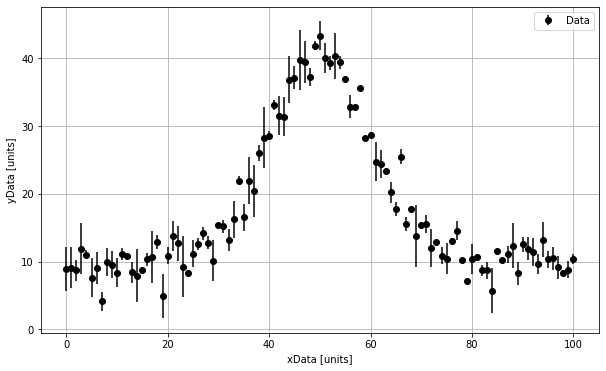

In [8]:
# import the packages needed
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Let us first generate some non-linear x-y data with uncertainties for the y-variable. 
# The data will follow a Gaussian distribution with some noise to make it more realistic.
# The error on the y-values will be randomly generated.

def NoisyGaussian(xData, a, b, c, d):
    y = a * np.exp((-1*(xData-b)**2)/(2*c**2))
    noise = np.random.normal(0,2,101)
    y = y + noise + d
    return y

xData = np.linspace(0,100,101)
yData = NoisyGaussian(xData, 30, 50, 10, 10)
yError = np.random.normal(0,2,101)

# Let us then plot this data to see what it looks like.
plt.figure(figsize=(10,6))
plt.errorbar(xData, yData, yerr = yError, marker = 'o', linestyle = ' ', color = 'k', label = 'Data')
plt.xlabel('xData [units]')
plt.ylabel('yData [units]')
plt.legend()
plt.grid()
plt.show()

The amplitude is : 30.1 +/- 0.1 units
The mean is : 51.1 +/- 0.2 units
The standard deviation is : 10.9 +/- 0.2 units
The background is : 11.2 +/- 0.1 units


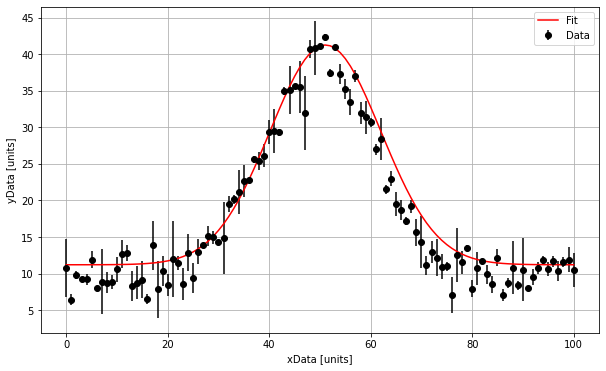

In [3]:
# To use curve fit, we need to do define the function (model) that we are going to fit 
# to the data. In this case a Gaussain.

def Gaussian(xData, a, b, c, d):
    y = a * np.exp((-1*(xData-b)**2)/(2*c**2)) + d
    return y

# We then use curve_fit, which requires the function, the x-data, y-data and starting estimates for the 
# parameters we are wishing to optimise (a = amplitude, b = mean, c = standard deviation, d = background noise).
# If we want to do a weighted regression we can add the y-errors. We can also set upper and lower bounds for
# these parameters if curve_fit is struggling. The optimised parameters are saved in an array called "popt"
# and we can derive the errors from an array called "pcov"

Guesses = [25, 50, 15, 11]
popt, pcov = curve_fit(Gaussian, xData, yData, sigma = yError, p0 = Guesses)
perr = np.sqrt(np.diag(pcov))

# We can then extract the fit results and superimpose our fit onto our plot:

print("The amplitude is :", np.round(popt[0],1), "+/-", np.round(perr[0],1), "units")
print("The mean is :", np.round(popt[1],1), "+/-", np.round(perr[1],1), "units")
print("The standard deviation is :", np.round(popt[2],1), "+/-", np.round(perr[2],1), "units")
print("The background is :", np.round(popt[3],1), "+/-", np.round(perr[3],1), "units")

plt.figure(figsize=(10,6))
plt.errorbar(xData, yData, yerr = yError, marker = 'o', linestyle = ' ', color = 'k', label = 'Data')
plt.plot(xData, Gaussian(xData, *popt), marker = ' ', linestyle = '-', color = 'r', label = 'Fit')
plt.xlabel('xData [units]')
plt.ylabel('yData [units]')
plt.legend()
plt.grid()
plt.show()

---
# Orthogonal Distance Regression

The method of using curve_fit above is great for performing a weighted regression when we only have errors associated with the independent-variable. However, as you will have experienced in the labs, it is often the case that there are errors associated with the dependant variables as well. For example, if you are taking measurements of temperature at different points along a bar, the position of the temperature probe along the bar will have some sort of measurement uncertainty.

If the uncertainties associated with the measurement of the dependant variable are no all equal, this should be taken into consideration when performing the regression. Data points with larger error bars should have less influence on the results of the fitting routine.

When we have errors associated with both the dependant and independant variable we need to employ **Orthogonal Distance Regression (ODR)**. The key difference between and a regular least squares regression is that the residuals that we are minimising are orthogonal. Take a look at the plot below where I have crudely drawn the the residuals that are minimised in ODR. As orthogonal residuals are being used, weighting factors for both the $x$ and $y$ errors can be calculated and included in the regression analysis using this method.

![](ODR_vs_OLS.png)


## ODR in Python

To perform ODR in Python, we need to use the scipy.ODR. The steps for performing ODR are similar to performing regression using curve fit. Let's work through an example using some more randomly generated Gaussian data, but this time with errors on the dependant variable too. 

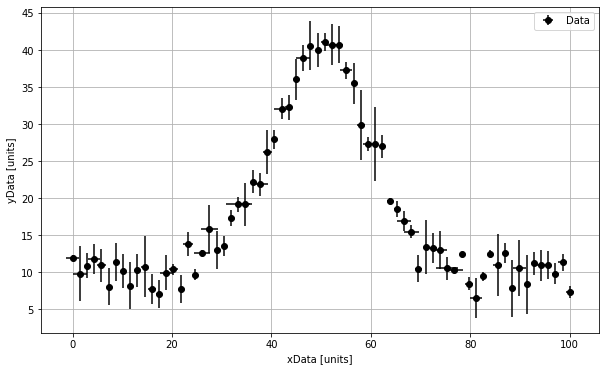

In [4]:
from scipy import odr

# Let us first generate some non-linear x-y data with uncertainties on both x and y. 
# The data will follow a Gaussian distribution with some noise to make it more realistic.
# The error on the x and y-values will be randomly generated.

def NoisyGaussian(xData, a, b, c, d):
    y = a * np.exp((-1*(xData-b)**2)/(2*c**2))
    noise = np.random.normal(0,2,70)
    y = y + noise + d
    return y

xData = np.linspace(0,100,70)
yData = NoisyGaussian(xData, 30, 50, 10, 10)
yError = np.random.normal(0,2,70)
xError = np.random.normal(0,1,70)

# Let us then plot this data to see what it looks like.
plt.figure(figsize=(10,6))
plt.errorbar(xData, yData, yerr = yError, xerr = xError, marker = 'o', linestyle = ' ', color = 'k', label = 'Data')
plt.xlabel('xData [units]')
plt.ylabel('yData [units]')
plt.legend()
plt.grid()
plt.show()

The amplitude is : 27.5 +/- 1.3 units
The mean is : 51.1 +/- 0.5 units
The standard deviation is : 11.1 +/- 0.5 units
The background is : 11.1 +/- 0.3 units


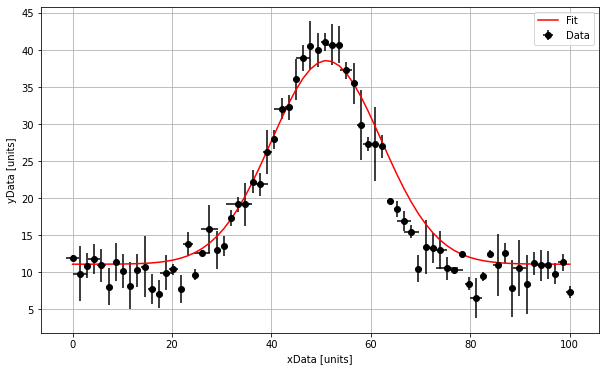

In [5]:
import numpy as np
from scipy import odr

# Define the model function for fitting
def Gaussian_ODR(B, xData):
    y = B[0] * np.exp((-1*(xData-B[1])**2)/(2*B[2]**2)) + B[3]
    # a = B[0], b = B[1], c = B[2], d = b = B[3]
    return y

# This function is defined here for plotting once the regression is complete
def Gaussian(xData, a, b, c, d):
    y = a * np.exp((-1*(xData-b)**2)/(2*c**2)) + d
    return y

# Create a model instance (this is an extra step we have to perform when using Scipy.ODR)
Gaussian_Model = odr.Model(Gaussian_ODR)

# Create a RealData object containing the data and their associated errors
data = odr.RealData(xData, yData, sx = xError, sy = yError)

# Set up the ODR object with an initial guess (beta0) for the parameters
odr_instance = odr.ODR(data, Gaussian_Model, beta0=[30, 50, 10, 10])

# Run the ODR
output = odr_instance.run()

# Retrieve the fitted parameters and their uncertainties
Amplitude, Mean, Stdev, Background = output.beta  # Fitted parameters
ErrorAmplitude, ErrorMean, ErrorStdev, ErrorBackground = output.sd_beta  #uncertainties

# Print and plot the results

print("The amplitude is :", np.round(Amplitude,1), "+/-", np.round(ErrorAmplitude,1), "units")
print("The mean is :", np.round(Mean,1), "+/-", np.round(ErrorMean,1), "units")
print("The standard deviation is :", np.round(Stdev,1), "+/-", np.round(ErrorStdev,1), "units")
print("The background is :", np.round(Background,1), "+/-", np.round(ErrorBackground,1), "units")

plt.figure(figsize=(10,6))
plt.errorbar(xData, yData, xerr = xError, yerr = yError, marker = 'o', linestyle = ' ', color = 'k', label = 'Data')
plt.plot(xData, Gaussian(xData, Amplitude, Mean, Stdev, Background), marker = ' ', linestyle = '-', color = 'r', label = 'Fit')
plt.xlabel('xData [units]')
plt.ylabel('yData [units]')
plt.legend()
plt.grid()
plt.show()

### Scipy.ORD vs Curve_fit

You can see in the code above that the way we perform our ODR is a little different to how we would perform a weighted regression using curve_fit. Take note of the following key difference:

1. When defining the functionm, rather than define individual parameters to be optimised as the arguements, we must put these into an array and then call the individual parameters from the array in our function.

2. Once we have defined our model function, we have to create a model instance (e.g. "Gaussian_Model = odr.Model(Gaussian_ODR)")

3. We have to create a RealData Object containing our $x-y$ data and associated errors. (e.g. "data = odr.RealData(xData, yData, sx = xError, sy = yError)").

After this it is quite similar to using curve_fit. We can do the ODR and extract the optimised parameters from an output array. This is similar to using curve_fit and extracting the optimised parameters from "popt", except this time we can extract our optimised parameters and their associated uncertainties from "output.beta" and "output.sd_beta".

We can then feed out optimised parameters back into our usual Gaussian function to superimpose the model onto the plot.